<a href="https://colab.research.google.com/github/UnplugCharger/Advent-of-code-2021/blob/master/Zindi_Waaldhawi_Challenge_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q cython pyyaml
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pycocotools>=2.0.2

In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14591, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 14591 (delta 0), reused 6 (delta 0), pack-reused 14583
Receiving objects: 100% (14591/14591), 5.96 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (10549/10549), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 151 kB 45.1 MB/s 
     |████████████████████████████████| 1.4 MB 63.2 MB/s 
     |████████████████████████████████| 548 kB 58.6 MB/s 
     |████████████████████████████████| 248 kB 56.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |██████

# New Section

In [ ]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 4.9 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

numpy      : 1.21.6
pandas     : 1.3.5
pycocotools: 2.0.6
torch      : 1.12.1+cu113
torchvision: 0.13.1+cu113
detectron2 : not installed



In [ ]:
!nvidia-smi

Mon Nov  7 09:01:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |  15086MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob
import math

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from shapely import wkt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

AttributeError: ignored

In [ ]:
dir = "/content/drive/MyDrive/zindi_ball_worm"

In [ ]:
!ls dir

ls: cannot access 'dir': No such file or directory


In [ ]:
worm_df = pd.read_csv(f"{dir}/Train.csv")
print(worm_df.shape)
worm_df.head()

(9900, 3)


,image_id_worm,worm_type,number_of_worms
0,id_0002ea6f15c7fa6f4c221783.jpg,pbw,51
1,id_0005ef295aafe6acc63587db.jpg,pbw,8
2,id_00084298dd030a500033ff78.jpg,NaN,0
3,id_00093f2c76f6488737325859.jpg,pbw,12
4,id_000b2e6c437c643f25d4a6c3.jpg,pbw,87


In [ ]:
bboxes = pd.read_csv(f"{dir}/images_bboxes.csv")
print(bboxes.shape)
bboxes.head()

(140233, 3)


,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377..."
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.81999..."
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129...."
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2090.216399557101 1537.2100674812148...
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2342.2568587778546 1676.304250464547...


In [ ]:
print(len(bboxes["image_id"].unique()))

9737


In [ ]:
bboxes.isna().any()

image_id     False
worm_type     True
geometry      True
dtype: bool

In [ ]:
bboxes.dropna(inplace=True)

In [ ]:
print(len(bboxes["image_id"].unique()))

6479


In [ ]:
bboxes.shape

(136975, 3)

In [ ]:
# test_df=bboxes.iloc[:30,:]

In [ ]:
from shapely.wkt import loads

In [ ]:
# dataset = []
# for index , row in tqdm(bboxes.iterrows(),total=bboxes.shape[0]):
#   image = Image.open(f'{dir}/images/{row["image_id"]}')
#   image_name = row["image_id"]
#   height =image.size[1]
#   width = image.size[0]

#   wkt_string=row["geometry"]
#   bbox = loads(wkt_string)
#   bbox =bbox.bounds
  

#   data = {}

#   data['file_name']=image_name
#   data['width'] =width
#   data['height'] = height
#   data['x_min']=math.ceil(bbox[0])
#   data['y_min']=math.ceil(bbox[1])
#   data['x_max']=math.ceil(bbox[2])
#   data['y_max']=math.ceil(bbox[3])
#   data['class_name']=row['worm_type']

  
#   dataset.append(data)

100%|██████████| 136975/136975 [27:08<00:00, 84.11it/s] 


In [ ]:
len(dataset)

136975

In [ ]:
df=pd.DataFrame(dataset)

In [ ]:
df = pd.read_csv(f'{dir}/worm.csv')
df.head()


,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,id_8ada71185e18dc8838b4925b.jpg,3072,3072,2378,157,2479,298,pbw
1,id_8ada71185e18dc8838b4925b.jpg,3072,3072,716,1222,940,1320,pbw
2,id_8ada71185e18dc8838b4925b.jpg,3072,3072,1130,1559,1560,1967,abw
3,id_bc86d3cfd0c0463fa5cae33e.jpg,4000,3000,1744,1538,2091,1800,abw
4,id_bc86d3cfd0c0463fa5cae33e.jpg,4000,3000,2163,1677,2343,1953,abw


In [ ]:
df.class_name.value_counts()

pbw    127752
abw      9223
Name: class_name, dtype: int64

In [ ]:
df.isna().any()

file_name     False
width         False
height        False
x_min         False
y_min         False
x_max         False
y_max         False
class_name    False
dtype: bool

In [ ]:
len(df['file_name'].unique())

6479

In [ ]:
df.to_csv(f"{dir}/worm.csv",index=False)

In [ ]:
def annotate_image(annotations,resize=True):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'{dir}/images/{file_name}'),cv2.COLOR_BGR2RGB)
  for i , a  in annotations.iterrows():
    cv2.rectangle(img,(a.x_min,a.y_min),(a.x_max,a.y_max),(0,255,0),2)
  if not resize:
    return img
  return cv2.resize(img,(384,384),interpolation=cv2.INTER_AREA)

(-0.5, 647.5, 1151.5, -0.5)

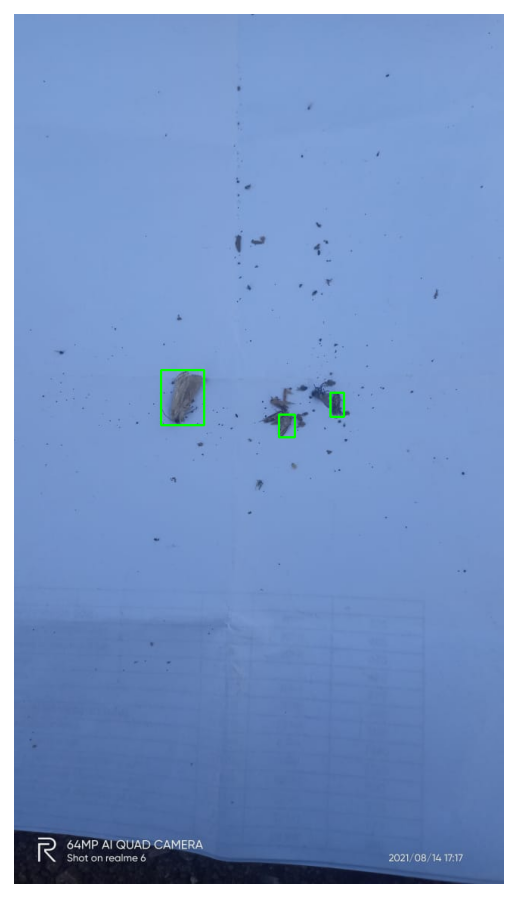

In [ ]:
image_df=df[df.file_name==df.file_name.unique()[3]]
img = annotate_image(image_df,resize=False)
plt.imshow(img)
plt.axis('off')

In [ ]:
unique_files = df.file_name.unique()
train_files = set(
    np.random.choice(
        unique_files,int(len(unique_files)*0.95),replace=False
    )
)

In [ ]:
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]
print(train_df.shape, test_df.shape)

(128945, 8) (8030, 8)


In [ ]:
classes = df.class_name.unique().tolist()
classes

['pbw', 'abw']

In [ ]:
IMAGES_PATH = f'{dir}/images'

In [ ]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id , image_name in enumerate(df.file_name.unique()):
    record ={}
    image_df = df[df.file_name==image_name]
    file_path = f'{IMAGES_PATH}/{image_name}'

    
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts



In [ ]:
for d in ['train','val']:
  DatasetCatalog.register(f'worms_{d}',lambda d=d:create_dataset_dicts(train_df if d=='train' else test_df,classes))
  MetadataCatalog.get(f'worms_{d}').set(thing_classes=classes)
  worm_metadata = MetadataCatalog.get('worms_train')

In [ ]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    # "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
    "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [ ]:
cfg.DATASETS.TRAIN = ("worms_train",)
cfg.DATASETS.TEST = ("worms_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [ ]:
# Concentarte here 

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = (100, 1000)
cfg.SOLVER.GAMMA = 0.05

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/07 08:55:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[11/07 08:56:02 d2.engine.train_loop]: Starting training from iteration 0
ERROR [11/07 08:56:24 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/content/detectron2_repo/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/content/detectron2_repo/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/content/detectron2_repo/detectron2/engine/train_loop.py", line 286, in run_step
    losses.backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 396, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 175, in backward
    allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
RuntimeError: CUDA out of memory. Tried to allocate 264.00 MiB (GPU 0; 14.76 GiB total capacity; 12.73 GiB al

RuntimeError: ignored